In [29]:
import os
import numpy as np
import pandas as pd
from dotenv import load_dotenv
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

In [30]:
PREPARED_DATASET = 'dataset/prepared/'

In [31]:
def load_raw_data(file_name):
    input_path = os.path.join(PREPARED_DATASET, file_name)
    df = pd.read_csv(input_path, sep="|", names=["x", "y"])
    x = df["x"].values
    y = df["y"].values
    return x, y

In [32]:
def normalize_data(x: list[float], y: list[float]):
    # нормализация по X и Y
    x_norm = (x - np.min(x)) / (np.max(x) - np.min(x))
    y_norm = (y - np.min(y)) / (np.max(y) - np.min(y))
    return x_norm, y_norm

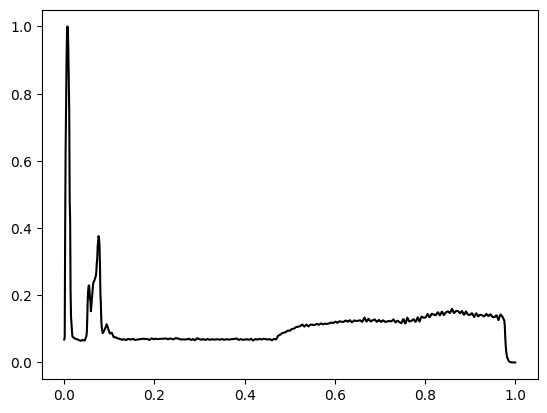

In [33]:
x_raw, y_raw = load_df("norm.csv")
x, y = normalize_data(x, y)
plt.plot(x, y, color="black")

In [21]:
def load_prepared_data(file_name, target_length=1000):
    input_path = os.path.join(PREPARED_DATASET, file_name)
    df = pd.read_csv(input_path, sep="|", names=["x", "y"])
    x_raw = df["x"].values
    y_raw = df["y"].values

    # нормализация Y
    y_norm = (y_raw - np.min(y_raw)) / (np.max(y_raw) - np.min(y_raw))

    f = interp1d(np.linspace(0, 1, len(y_norm)), y_norm, kind='linear')
    
    # нормализация X
    x_new = np.linspace(0, 1, target_length)
    y_interp = f(x_new)
    
    return x_new, y_interp

In [22]:
file_names = ["norm.csv", "defect1.csv", "defect2.csv"]
X_signals = []
Y_masks = []

for file in file_names:
    x, y = load_prepared_data(file)

    X_signals.append(y)

    mean = np.mean(y)
    std = np.std(y)
    mask = (y > mean + 1.5 * std).astype(float)
    Y_masks.append(mask)

X_signals = np.array(X_signals)[..., np.newaxis]
Y_masks = np.array(Y_masks)[..., np.newaxis]

In [7]:
def create_model(input_length):
    # для сегментации будем использовать несколько слоев
    model = Sequential([
        Conv1D(32, kernel_size=5, activation='relu', input_shape=(input_length, 1)),
        MaxPooling1D(pool_size=2),
        Conv1D(64, kernel_size=5, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(input_length, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy')
    return model

In [11]:
model = create_model(X_signals.shape[1])
model.summary()

model.fit(X_signals, Y_masks, epochs=20, batch_size=4, validation_split=0.2)

/home/marat/venv/jupyter-vim/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 996, 32)        │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 498, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 494, 64)        │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 247, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 15808)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     2,023,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1000)           │       129,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,163,048 (8.25 MB)

 Trainable params: 2,163,048 (8.25 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.6931 - val_loss: 0.6904
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.6858 - val_loss: 0.6850
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 0.6720 - val_loss: 0.6755
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: 0.6489 - val_loss: 0.6603
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.6150 - val_loss: 0.6380
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 0.5697 - val_loss: 0.6074
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.5140 - val_loss: 0.5675
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 0.4502 - val_loss: 0.5180
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.3823 - val_loss: 0.4604
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.3152 - val_loss: 0.3982
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.2535 - val_loss: 0.3362
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.2003 - val_loss:

In [12]:
def predict_key_points(model, file_name, max_regions=2):
    x, y = load_prepared_data(file_name)

    X = y.reshape(1, -1, 1)
    mask = model.predict(X)[0]

    threshold = 0.5
    key_indices = [i for i in range(len(mask)) if mask[i] > threshold]

    grouped_regions = []
    current_region = []
    for i in range(len(key_indices)):
        if not current_region or key_indices[i] - key_indices[i - 1] <= 10:
            current_region.append(key_indices[i])
        else:
            grouped_regions.append(current_region)
            current_region = [key_indices[i]]
    if current_region:
        grouped_regions.append(current_region)

    top_regions = sorted(grouped_regions, key=lambda r: len(r), reverse=True)[:max_regions]
    top_centers = [int(np.mean(region)) for region in top_regions]

    plt.figure(figsize=(12, 4))
    plt.plot(x, y, label="Signal", color="black")
    for pt in top_centers:
        plt.axvline(x[pt], color="pink", linestyle="--", linewidth=2, label="Key Point")
    plt.title(f"Key points in {file_name}")
    plt.legend()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


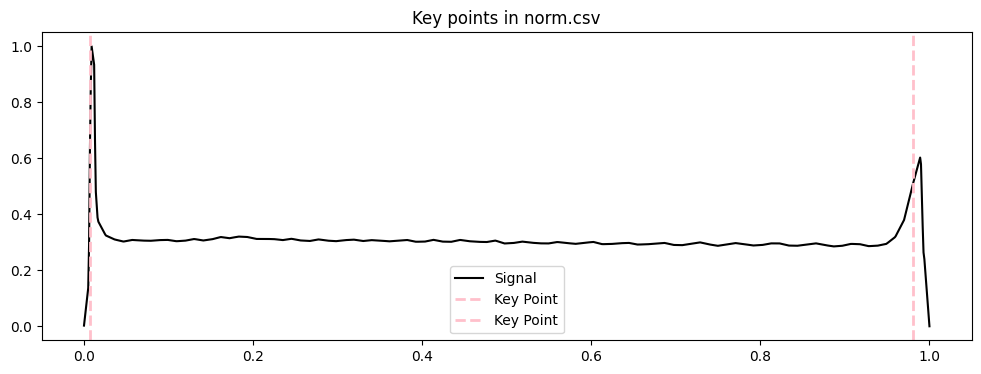

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


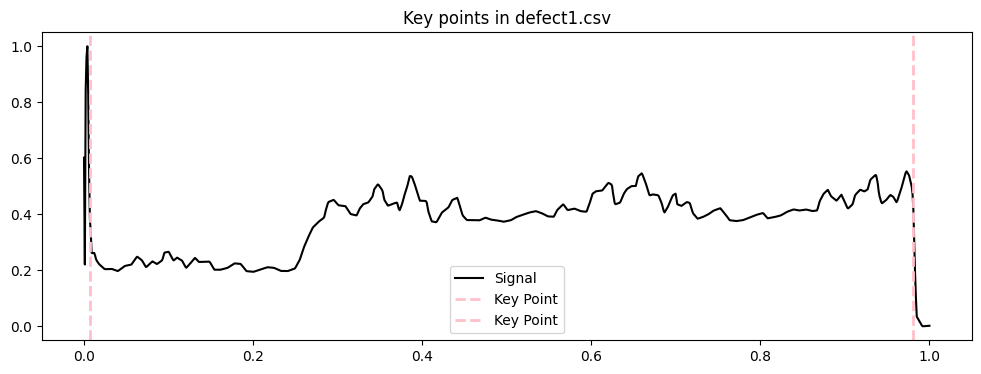

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


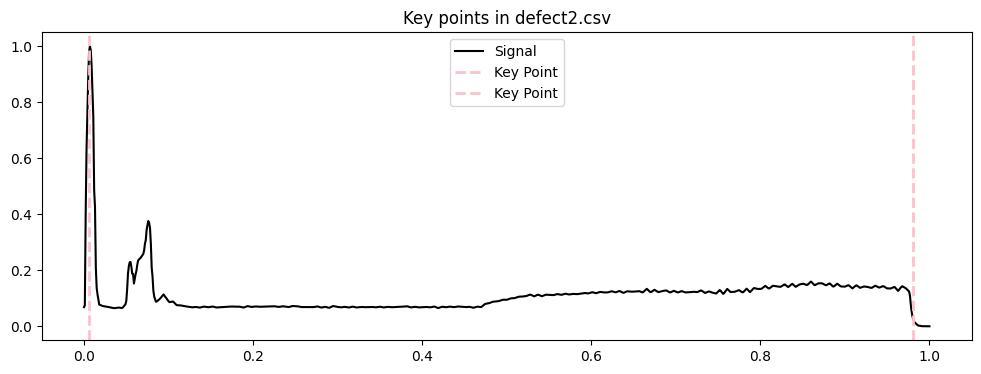

In [13]:
predict_key_points(model, "norm.csv")
predict_key_points(model, "defect1.csv")
predict_key_points(model, "defect2.csv")